# PZ-model

## Model

(Using the same Fourier transform convention as in allpole.ipynb.)

Impulse response for $K$ poles $p_k = -\pi y_k + 2\pi i x_k$ has the same form as an AP (all-pole) model:

$$ h(t; p) = (t \geq 0) \times \sum_{k=1}^K c_k e^{p_k t} + c_k^* e^{p_k^* t}$$

But now each coefficient $c_k$ is determined by 2 free parameters $(a_k,b_k) \in \mathbb{R}$:

$$ c_k = {a_k - ib_k \over 2} \iff (a_k = c_k + c_k^*, b_k = ic_k - ic_k^*)$$

such that

$$ c_k e^{p_k t} + c_k^* e^{p_k^* t} = (a_k \cos(2\pi i x_k) + b_k \sin(2\pi i x_k)) \exp(-\pi y_k t) $$

The transfer function follows immediately from the form of the impulse response $h(t; p)$:

$$ \tilde{h}(x; p) = \sum_{k=1}^K {c_k \over 2\pi i x - p_k} + {c_k^* \over 2\pi i x - p_k^*} $$

[Note that the AP model can also be written in this way, but the expression for $c_k$ is more involved (the excluded pole product).]

In this form it is easy to see that the analytical spectral tilt at $x \rightarrow \infty$ should be about -6 dB/oct, independent of $K$, since $\tilde{h}(\infty, p) \propto 1/x$. Ofcourse the amplitudes can conspire in such ways that, e.g., the model collapses to an AP model with characteristic $(-12K)$ dB/oct tilt.

Collecting the terms, we get a proper transfer function in rational form:

$$ \tilde{h}(x; p) = {N(2\pi i x) \over \prod_{k=1}^K (2\pi i x - p_k)(2\pi i x - p_k^*)}$$

where $N(2\pi i x)$ is a polynomial of degree at most $2K - 1$.

## Normalization

If we adapt the same normalization as the AP, i.e., $\tilde{h}(0; p) := 1$, we would have to divide $\tilde{h}(x; p)$ **and $h(t; p)$** by the following factor:

$$DC = -2 \sum_{k=1}^K {Re(c_k p_k^*) \over |p_k|^2}$$

However, doing this would stop $h(t; p)$ from being purely linear in the amplitudes (since $DC$ depends on $c_k = {a_k - ib_k \over 2}$) and this is counterproductive; much better to normalize implicitly using the ME prior that yields a MVN over $(a,b)$ directly. Below we show that this yields superior normalization compared to AP -- it yields impulse responses $h(t; p)$ whose peak amplitudes are O(1), just what we like because our data peak amplitude is O(2) and our source DGF peak amplitude is O(5).

## Comparison with AP model

Disadvantages:
- Twice as much parameters: $(4K)$ (PZ) instead of $(2K)$ (AP)

Advantages:
- Automatically regularizes itself ("nested model")
- Can model more realistic spectral tilt
- Easier normalization such that the peak amplitudes of the impulse response $h$ are O(1) using our ME prior
- Can model zeros more easier
- Independent amplitudes of the formant peaks, which seems intuitively desirable

In [1]:
%run init.ipy

from vtr.prior import bandwidth
from dgf import core
from lib import constants
from vtr.prior import allpole
from vtr import spectrum

from vtr.prior import polezero

2022-11-24 22:49:25.587856: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


[Memory]6.0s, 0.1min    : Loading get_aplawd_training_pairs...


[Memory]31.9s, 0.5min   : Loading run_nested...
[Memory]36.0s, 0.6min   : Loading run_nested...
[Memory]40.0s, 0.7min   : Loading run_nested...
[Memory]43.8s, 0.7min   : Loading run_nested...
[Memory]43.8s, 0.7min   : Loading get_aplawd_training_pairs...


[Memory]52.8s, 0.9min   : Loading get_vtrformants_training_data...
[Memory]67.3s, 1.1min   : Loading run_nested...
[Memory]68.8s, 1.1min   : Loading run_nested...
[Memory]70.4s, 1.2min   : Loading run_nested...
[Memory]72.0s, 1.2min   : Loading run_nested...
[Memory]72.0s, 1.2min   : Loading get_vtrformants_training_data...


## The amplitude prior

[Based on: von der Linden (2014) Eq. (21.67) p. 348-349]

The impulse response is just a basis function expansion with $E=2K$ terms with amplitudes $a_k, b_k$:
$$ \begin{align}
h(t; p) &= (t \geq 0) \times \sum_{k=1}^K c_k e^{p_k t} + c_k^* e^{p_k^* t} \\
&= (t \geq 0) \times \sum_{k=1}^K (a_k \cos(2\pi i x_k) + b_k \sin(2\pi i x_k)) \exp(-\pi y_k t) \\
&= \sum_{i=1}^{E=2K} \alpha_i \phi_i(t)
\end{align}$$
where $(\alpha_i = a_i \text{ if $i \leq K$ else } b_{i-K})$ and we tried to follow the notation of von der Linden.

So we can assign a prior to the amplitudes based on the energy (wrongly called $P(a)$ suggesting power -- but power needs to be divided by time) of the impulse response:
$$
\mathcal{E}(\alpha) = \int dt h(t; p)^2 = \sum_{ij=1}^E a_i a_j S_{ij} = \mu^2
$$
Here $S_{ij}$ is the overlap matrix which can be calculated analytically.
Similar calculations are done in @Bretthorst1991 in the discrete time domain, but our continous formulation (the $\int$ instead of $\sum$) allows for efficient close-form formulas. These are given in `vtr/overlapmatrix.nb`. Then the MVN prior for the amplitudes given the poles $p$ is
$$ p(a|p,\mu^2) = MVN(0, \Sigma) $$ where $$ \Sigma = {\mu^2 \over 2K} S(p)^{-1}$$.

Note that $S_{ij}$ and $\mu^2$ have dimensions of time. In our case we assign $\mu^2 = O(1) = 1\ msec$.
Why?
The normalized-to-unit-power speech data has typical peak amplitude O(2).
The source prior typically yields O(5) peak amplitude in DGF waveform.
Therefore we want our impulse response $h(t)$ to have O(1) peak amplitude.
This is well accomplished by setting $\mu^2 = 1\ msec$.

(This is an example of why it is good to work in a scale where things are O(1), so that O(1) guesses for parameter are likely to succeed without putting any though in it.)

In [2]:
def samplexy(K = 3, prior = bandwidth.TFB_prior()):
    T, *xy = prior.sample(seed=jaxkey())
    x, y = np.split(np.array(xy), 2)
    x, y = x[:K], y[:K]
    return x, y

def eval_G(t, x, y):
    K = len(x)
    G = np.empty((len(t), 2*K))
    X, Y, T = x[None,:], y[None,:], t[:,None]
    
    G[:, :K] = np.cos(2.*np.pi*X*T)*np.exp(-np.pi*Y*T)
    G[:, K:] = np.sin(2.*np.pi*X*T)*np.exp(-np.pi*Y*T)
    return G # (N, m)

[Memory]75.2s, 1.3min   : Loading get_vtrformants_training_data...
[Memory]76.0s, 1.3min   : Loading run_nested...
[Memory]78.9s, 1.3min   : Loading run_nested...


0.8447208414488913

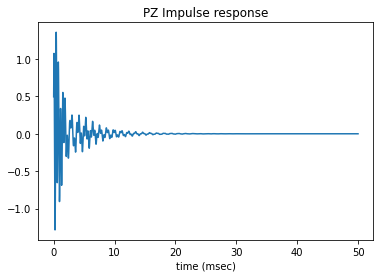

In [3]:
K = 3
x, y = samplexy(K)

fs = 1000 # kHz
dt = 1/fs # msec
t = np.arange(0., 50, dt) # msec
G = eval_G(t, x/1000, y/1000)

ab = polezero.amplitudes_prior_ppf(rand(2*K), x, y)

s = G @ ab
plot(t, s)
title("PZ Impulse response")
xlabel("time (msec)")
mu2 = np.dot(s, s)*dt
mu2

Test if the expected values $<\mu^2>$ is close to its prescribed value (1 msec):

1.1480468444028005

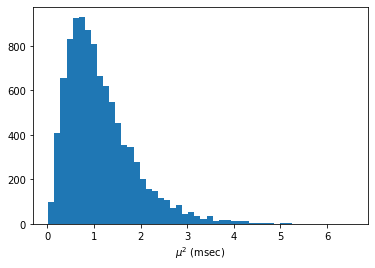

In [4]:
mu2s = []
for _ in range(10000):
    a = polezero.amplitudes_prior_ppf(rand(2*K), x, y)
    s = G @ a
    mu2 = np.dot(s, s)*dt
    mu2s += [mu2]

hist(mu2s, bins=50)
xlabel("$\mu^2$ (msec)")
mean(mu2s) # msec

## Check power spectrum

-5.819193068935812

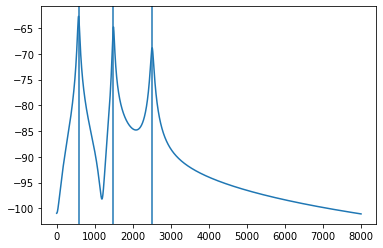

In [5]:
K = 3
x, y = samplexy()

ab = polezero.amplitudes_prior_ppf(rand(2*K), x, y)
f = constants.spectrum_frequencies(constants.TIMIT_FS_HZ)
power = polezero.transfer_function_power_dB(f, x, y, ab)
plot(f, power)
for xi in x: axvline(xi)
spectrum.fit_tilt(f, power)

### AP model as a special case of PZ

The PZ model includes the AP model as a special case, when the amplitudes $(a,b)$ take on specific values:

[ 0.03552367 -0.014678   -0.02084568  5.94030867 -3.83540763  0.10812462]


-28.859929778150022

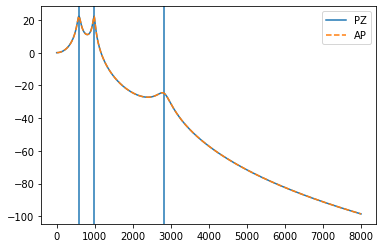

In [6]:
K = 3
x, y = samplexy()

# Calculate the amplitudes that turn the PZ into an AP
poles = core.make_poles(y, x)
c = core.pole_coefficients(poles)
a = real(c + conj(c))
b = real((1j)*(c - conj(c)))
ab_AP = np.concatenate((a, b))
print(ab_AP)

power = polezero.transfer_function_power_dB(f, x, y, ab_AP, normalize_gain=True)
plot(f, power, label="PZ")
for xi in x: axvline(xi)

plot(f, allpole.transfer_function_power_dB(f, x, y), '--', label="AP")
legend();

spectrum.fit_tilt(f, power)

But does the $p(a,b|p,\mu^2)$ prior place any mass at that specific point? **No.** We can check this in two ways:

1. Distribution of spectral tilt: tilt of 3-pole AP model is roughly -36 dB/oct, and this lies far away from the tilts of the PZ model

CPU times: user 4min 26s, sys: 0 ns, total: 4min 26s
Wall time: 4min 27s


-7.051593827559358

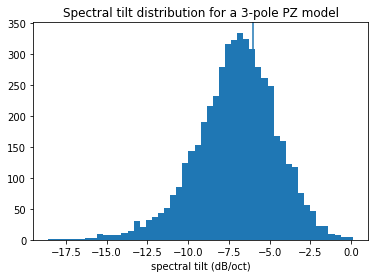

In [7]:
%%time
tilts = []

K = 3
f = constants.spectrum_frequencies(constants.TIMIT_FS_HZ)

for i in range(5000):
    x, y = samplexy()
    ab = polezero.amplitudes_prior_ppf(rand(2*K), x, y)
    power = polezero.transfer_function_power_dB(f, x, y, ab)
    
    F, B = spectrum.get_formants_from_spectrum(f, power)
    tilts += [spectrum.fit_tilt(f, power)]

hist(tilts, bins=50);
axvline(polezero.analytical_tilt())
title("Spectral tilt distribution for a 3-pole PZ model")
xlabel("spectral tilt (dB/oct)")
mean(tilts)

2. A direct check: where does the special point at which $(a,b) == $ `ab_AP` turn the PZ model into a "degenerate" AP model lie with respect to the distribution of the $(a,b)$ prior? Answer: far away. Blue points in the corner plot below: lie basically outside of the support of our ME prior for the $(a,b)$ amplitudes. And indeed, the typical peak amplitudes of the impulse response of the AP model are roughly 10x larger than those of the PZ model.

[ 0.03552367 -0.014678   -0.02084568  5.94030867 -3.83540763  0.10812462]


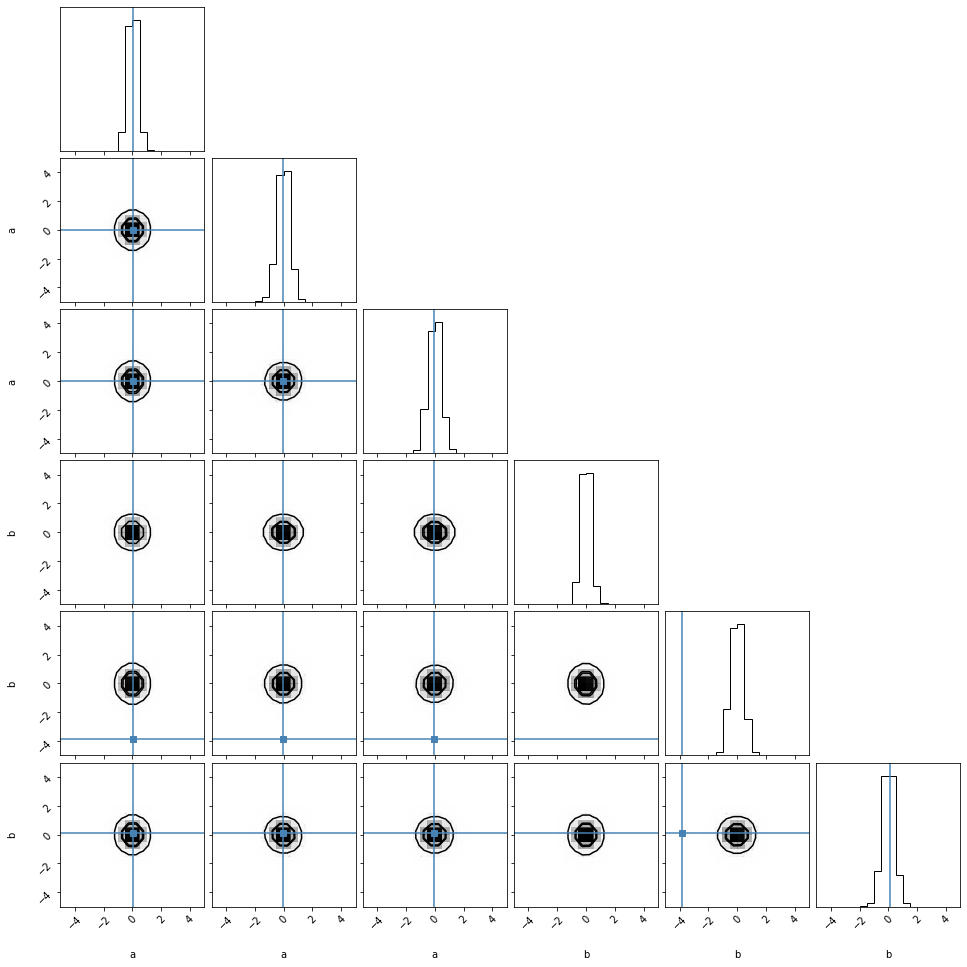

In [8]:
import corner
import itertools

print(ab_AP)

x, y = samplexy()
ab_samples = polezero.amplitudes_prior_ppf(rand(2*K, 1000), x, y).T

corner.corner(
    ab_samples,
    range = itertools.repeat((-5, 5), 2*K),
    labels = [*["a"]*K, *["b"]*K],
    smooth = 1.,
    truths = ab_AP
);

## Try a fit to a TFB sample

In [11]:
samples = bandwidth.get_TFB_samples()

[Memory]805.7s, 13.4min : Loading get_TFB_samples...


In [50]:
sample = samples[31]
K = 5
results = polezero.fit_TFB_sample(sample, K, 1111111)

________________________________________________________________________________
[Memory] Calling vtr.prior.polezero.run_nested...
run_nested(1111111, {'bootstrap': 10, 'nlive': 60, 'sample': 'rslice'}, {'maxcall': 300000, 'save_bounds': False})


1224it [10:34,  1.93it/s, +60 | bound: 62 | nc: 1 | ncall: 174290 | eff(%):  0.737 | loglstar:   -inf < -0.543 <    inf | logz: -18.083 +/-    nan | dlogz:  0.001 >  0.069]    

____________________________________________________run_nested - 634.7s, 10.6min


Summary
nlive: 60
niter: 1224
ncall: 174230
eff(%):  0.737
logz: -18.083 +/-  0.548


None

'Information (bans)'

6.501277289834603

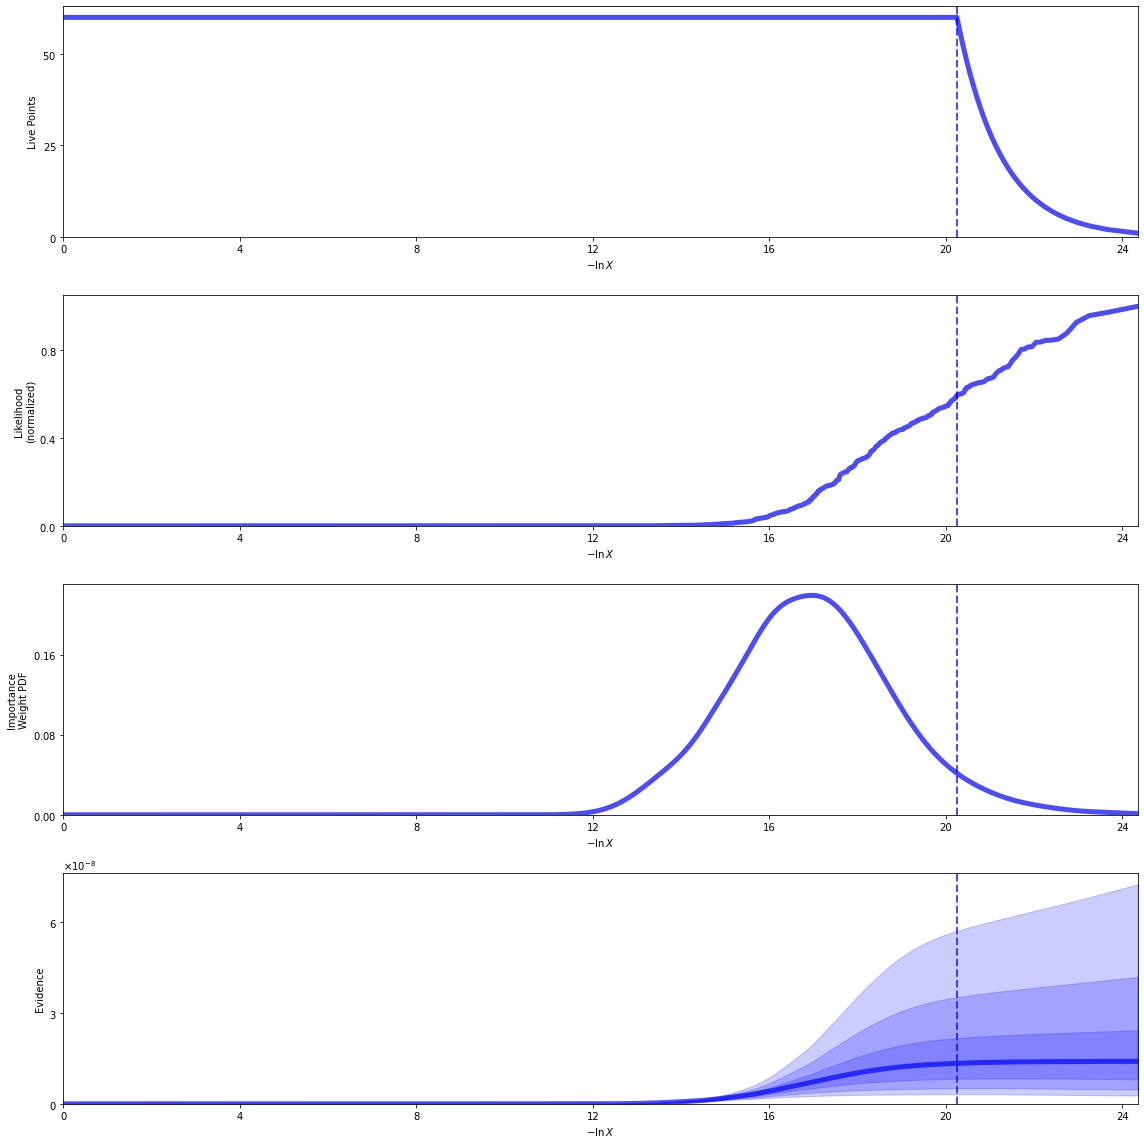

Quantiles:
x [(0.025, 321.9507229251321), (0.5, 332.7119057518585), (0.975, 337.51208219820086)]
Quantiles:
x [(0.025, 364.7078862826019), (0.5, 397.66503893022997), (0.975, 1042.0130180706428)]
Quantiles:
x [(0.025, 450.67734147484106), (0.5, 507.1040432843107), (0.975, 1532.6117275074514)]
Quantiles:
x [(0.025, 1513.563445417648), (0.5, 1531.1169140482418), (0.975, 2189.850151106542)]
Quantiles:
x [(0.025, 2070.337170591949), (0.5, 2153.9477607153713), (0.975, 2428.105588819407)]
Quantiles:
y [(0.025, 46.75083123414231), (0.5, 60.58267166216005), (0.975, 89.08567660148395)]
Quantiles:
y [(0.025, 310.11468134601586), (0.5, 2944.427923919427), (0.975, 4775.353231746133)]
Quantiles:
y [(0.025, 37.441088709080816), (0.5, 245.5147238910387), (0.975, 335.0381919733917)]
Quantiles:
y [(0.025, 36.77968163562396), (0.5, 76.723712195413), (0.975, 125.74625705177561)]
Quantiles:
y [(0.025, 154.4233559391206), (0.5, 204.00271565003166), (0.975, 1055.2764679418822)]
Quantiles:
a [(0.025, 0.186739

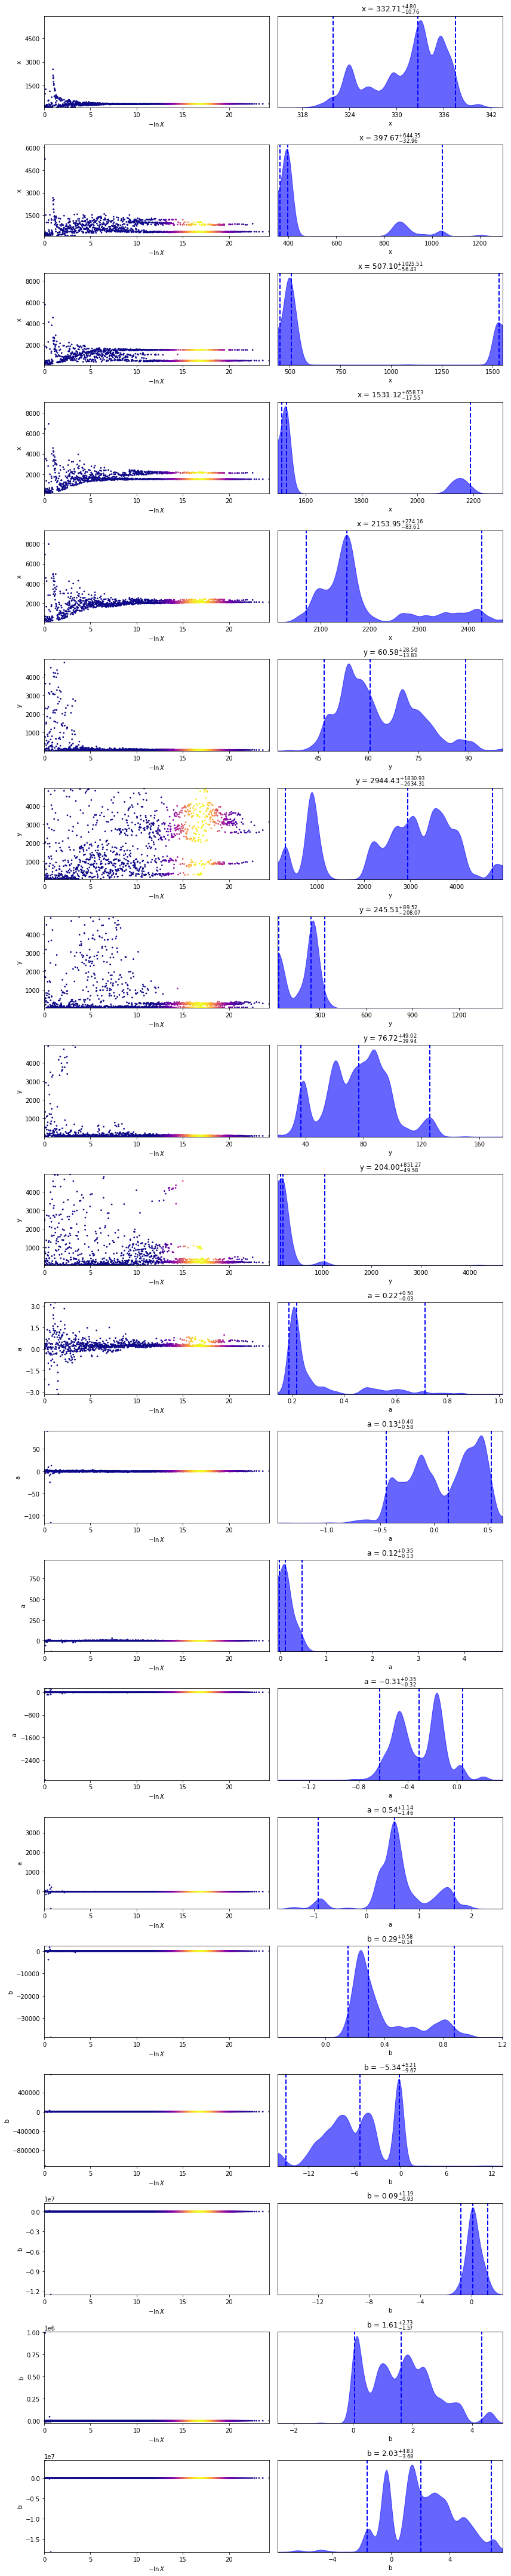

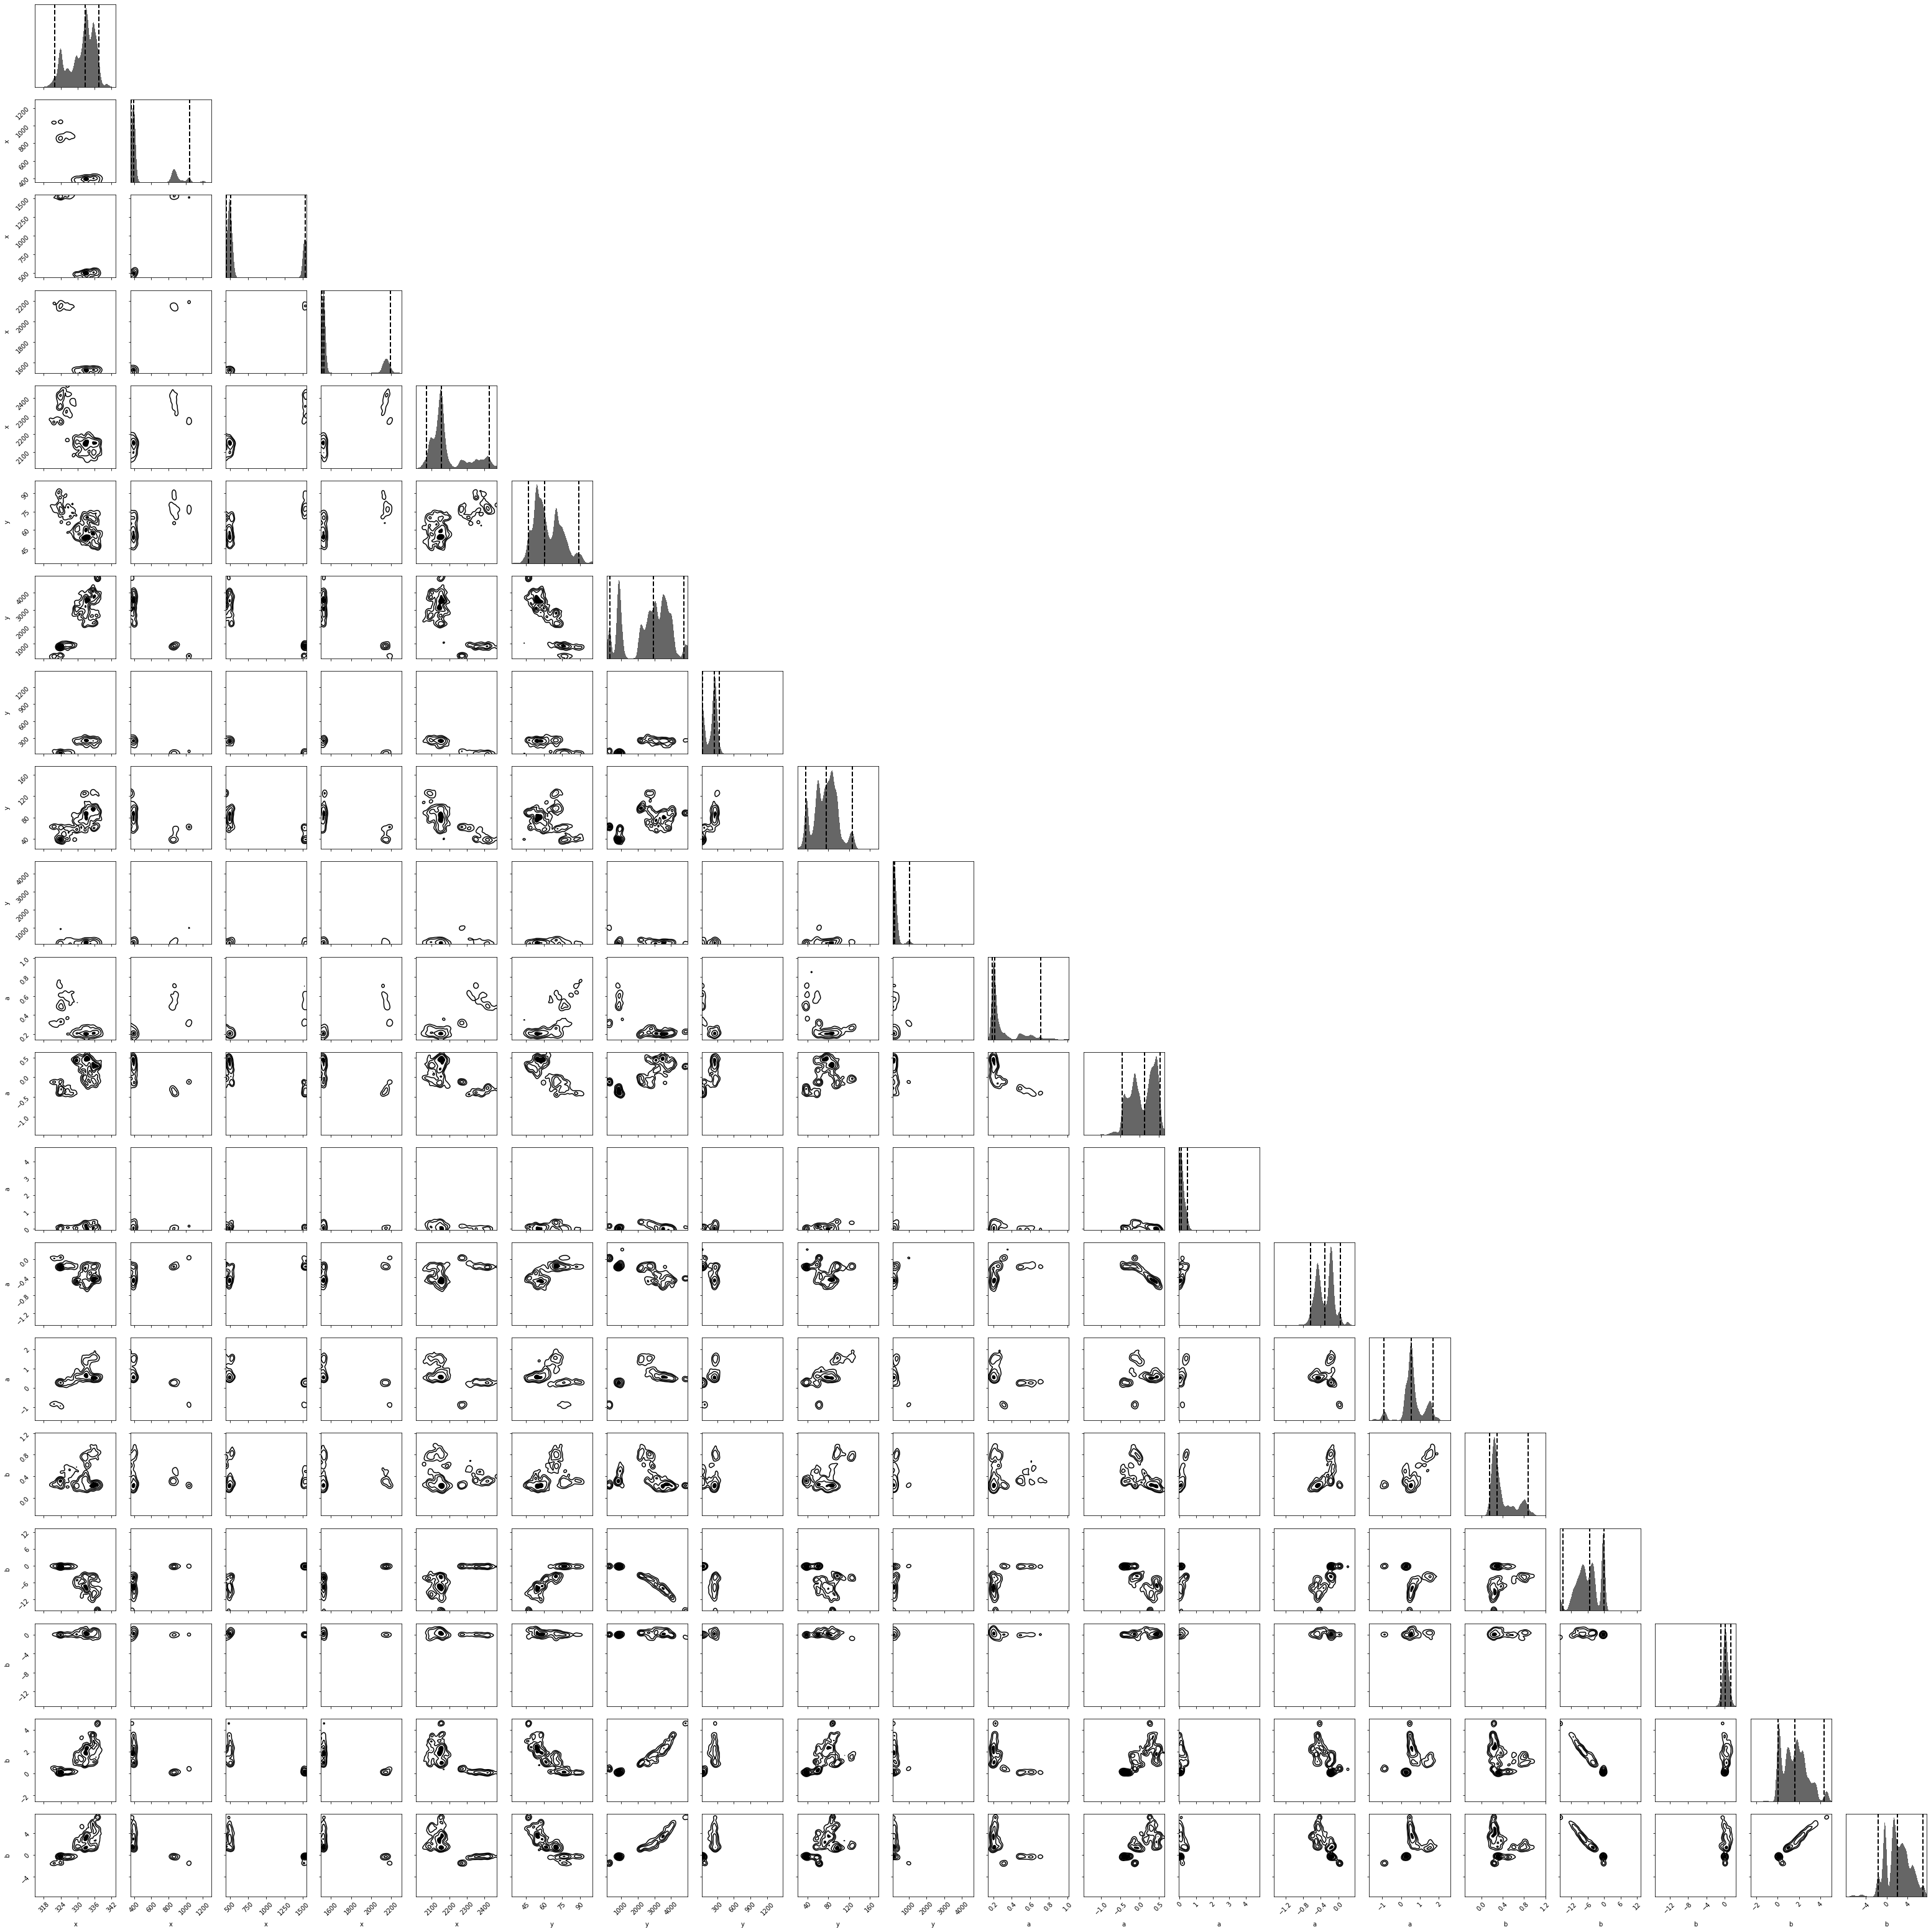

In [51]:
from lib import util
util.dyplot(results, (*["x"]*K, *["y"]*K, *["a"]*K, *["b"]*K))

-8.653334107127801 -6.020599913279624
2.898460482363224 0.40700439572069735 0.6916696053292202


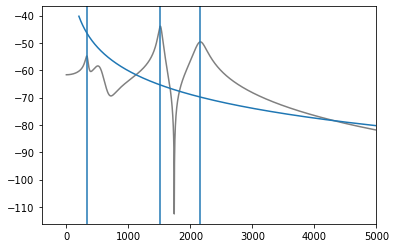

In [84]:
from vtr.prior.polezero import *

sample = samples[31]

def unpack(params):
    xy, ab = np.split(params, 2)
    x, y = np.split(xy, 2)
    return x, y, ab

def loglike_debug(
    params,
    f = sample['f'][::2],
    F_true = sample['F'],
    B_true = sample['B'],
    sigma_F = np.array([2., 7, 29]),
    sigma_B = np.array([4., 14, 58]),
    tilt_target = constants.FILTER_SPECTRAL_TILT_DB,
    sigma_tilt = constants.SIGMA_TILT_DB
):
    x, y, ab = unpack(params)
    
    power = transfer_function_power_dB(f, x, y, ab)
    plot(f, power, "grey")

    # Heuristically measure formants
    try:
        F, B = spectrum.get_formants_from_spectrum(f, power)
    except np.linalg.LinAlgError:
        return -np.inf

    if len(F) != 3:
        return -np.inf

    # Heuristically measure spectral tilt
    tilt = spectrum.fit_tilt(f, power)

    tilt, interp = spectrum.fit_tilt(f, power, return_interp=True)
    print(tilt, polezero.analytical_tilt())
    
    plot(f[f > 200], interp(f[f > 200]))
    
    for Fi in F: axvline(Fi)
    
    F_err = np.sum(((F - F_true)/sigma_F)**2)
    B_err = np.sum(((B - B_true)/sigma_B)**2)
    tilt_err = ((tilt - tilt_target)/sigma_tilt)**2

    print(F_err, B_err, tilt_err)
    
    return -(F_err + B_err + tilt_err)/2

loglike_debug(util.resample_equal(results, 1).squeeze())
#loglike_debug(util.resample_equal(results, 1).squeeze())
#loglike_debug(util.resample_equal(results, 1).squeeze())
xlim(None, 5000);